In [1]:
import numpy as np
from matplotlib import pyplot as plt
import theano as th
from theano import tensor as tt
from theano.tensor.shared_randomstreams import RandomStreams as RandomStreams
from theano.tensor.shared_randomstreams import raw_random

In [2]:
rng = RandomStreams()

In [3]:
th.config.floatX = 'float64'
th.config.exception_verbosity = 'high'

In [4]:
def transition_det(x):
    return 5*tt.sin(0.1*x)

def transition(x):
    return transition_det(x) + rng.normal(std=0.1, size=x.shape)

def emission_det(x):
    return tt.exp(5*x+0.1) + x

def emission(x):
    return emission_det(x) + rng.normal(std=1, size=x.shape)

In [5]:
inp = tt.vector(name='default input vector')

In [6]:
get_transition = th.function([inp], transition(inp), allow_input_downcast=True)
get_emission = th.function([inp], emission(inp), allow_input_downcast=True)

In [7]:
latent = [0.01]
for _ in range(1000):
    latent.append(get_transition(np.array([latent[-1]]))[0])

observe = get_emission(np.array(latent))

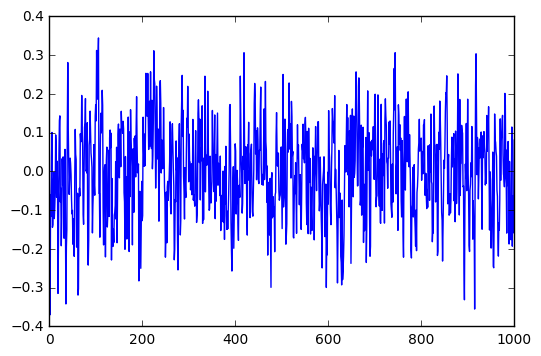

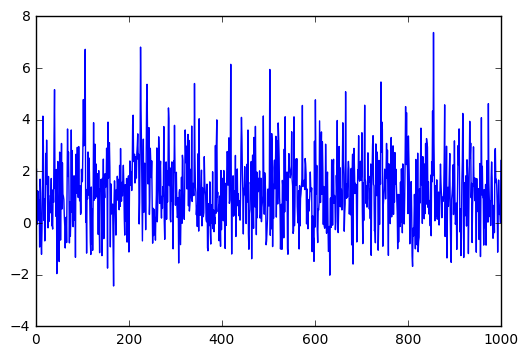

In [8]:
plt.plot(latent)
plt.show()
plt.plot(observe)
plt.show()

In [9]:
def prob(x, observation):
    pre = tt.exp(-(emission_det(x) - observation)**2/(2*1**2))
    return pre/pre.sum()

def resample(x, probs):
    return rng.choice(a=tt.arange(x.shape[0]), p=probs, replace=True, size=(300,), dtype='int64').T

def update(x):
    res, updates = th.scan(transition, non_sequences=x, n_steps=10)
    return res.reshape((-1,))[:3000]

In [10]:
observe_th = th.shared(np.array(observe),name='observe')
init_sample = th.shared(np.random.normal(scale=3,size=(3000,)), name='current sample')

In [11]:
def filt_iter (observation, x, y):
    probs = prob(y,observation)
    res = resample(y,probs)
    probs = probs[res]
    return y[res], update(x), probs/probs.sum()

results, updates = th.scan(filt_iter,
                           outputs_info = [{'initial':init_sample[:300]},{'initial':init_sample}, None],
                           sequences=observe_th)
results = [results[0], results[2]]

In [12]:
filtered = th.function([], results, updates=updates)

In [13]:
filt_distrib, filt_distrib_probs = filtered()

In [14]:
filt_distrib.shape

(1001, 300)

In [15]:
filt_distrib = np.array(filt_distrib)
filt_distrib = np.sort(filt_distrib, axis=1)

In [16]:
def step_back(x, probs):
    results, updates = th.map(lambda p: rng.choice(a=x.reshape((-1,)), replace=True,
                                                   p=p.reshape((-1,)), size=(1,), dtype=th.config.floatX), 
                              probs, name='traj mapper')
    return results.reshape((-1,)), updates

def back_sample(x, next_x):
    probs, updates = th.map(lambda piece: tt.exp(-((x - piece)**2)/(2*0.2**2)), next_x)
    probs /= tt.sum(probs, axis=1).reshape((-1,1))
    return step_back(x, probs)

In [17]:
def meshgrid(t1,t2):
    n = 100
    raise
v1 = tt.tile(tt.arange(0, n), (int(n),1))
v2 = tt.tile(tt.arange(0, n), (int(n),1)).T
v3 = tt.stack([v1.flatten(), v2.flatten()]).T
v3.eval()
    def inner(t):
        return th.map(lambda j: tt.stack([t,j]), sequences=tt.arange(t2))
    return (th.map(lambda i: inner(i), sequences=tt.arange(t1))[0]).reshape((-1,2))

In [18]:
def pxtp1x (x2,x1):
    return tt.exp(-(emission_det(x1)-x2)**2/(2*1**2))

In [19]:
def denum(xtp1, x, wt):
    return th.map(lambda xj: (wt*pxtp1x(xj, x)).sum(), xtp1)[0]

In [20]:
def intersum_no_denum(xtp1, x, next_wT):
    grid = meshgrid(*[x.shape[0]]*2)
    return th.map(lambda ij: next_wT[ij[1]]*pxtp1x(xtp1[ij[1]], x[ij[0]]), grid)[0].reshape((x.shape[0],x.shape[0]))

In [21]:
filt_distrib_th = th.shared(filt_distrib, name='filtered distribution')
filt_distrib_probs_th = th.shared(filt_distrib_probs, name='filtered distrib probabilities')

In [22]:
def interfun(xtp1, x, wt, next_wT):
    s = tt.sum((intersum_no_denum(xtp1, x, next_wT).T/denum(xtp1, x, wt)).T, axis=1)
    s = s*wt
    return s/s.sum()

In [23]:
results, updates = th.scan(interfun, 
                           outputs_info=[filt_distrib_probs_th[-1]],
                           go_backwards=True,
                           sequences=[filt_distrib_th[:-1], 
                                      filt_distrib_th[1:], 
                                      filt_distrib_probs_th[1:]])

In [24]:
smoother = th.function([], results[::-1], updates=updates)

In [25]:
%time smoothed = smoother()

CPU times: user 7min 49s, sys: 2.93 s, total: 7min 52s
Wall time: 7min 58s


In [60]:
tt.stack(tt.arange(10),-tt.arange(10)[::-1]).T.take([[1],[2]]).eval()

array([[-9],
       [ 1]])

In [ ]:
tt.take

In [44]:
tt.stack(tt.constant(1), tt.constant(1)).T.shape.eval()

array([2])

In [37]:
tt.stack(tt.arange(10),-tt.arange(10)).T.shape.eval()

array([10,  2])

In [34]:
tt.stack(tt.arange(5), tt.arange(5)).T.eval()

array([[0, 0],
       [1, 1],
       [2, 2],
       [3, 3],
       [4, 4]])

In [27]:
filt_distrib = filt_distrib[1:]

In [28]:
smm = []
for d, p in zip(filt_distrib, smoothed):
    #smm.append(np.random.choice(d, p=p, size=0, replace=True))
    smm.append(d*p)

In [29]:
smm = np.array(smm)

In [135]:
tt.arange(start=0, stop=1, step=0.1, dtype='float64').eval()

array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9])

In [137]:
interfun(tt.arange(1, step=0.1), tt.arange(1, step=0.1), tt.ones(10)/100, tt.ones(10)/100).eval()

array([  1.11544317e-001,   4.41356880e-002,   3.19567974e-003,
         2.06761352e-006,   2.86945254e-015,   9.77181138e-040,
         6.31647096e-107,   1.47930142e-290,   0.00000000e+000,
         0.00000000e+000])

In [139]:
filt_distrib.shape

(1001, 40)

In [18]:
def iterfun(x, next_x):
    bs = back_sample(x, next_x)
    return (bs[0], bs[1])

results, updates = th.scan(iterfun, 
                           sequences=filt_distrib_th[::-1], 
                           outputs_info=filt_distrib_th[-1])
results = results[::-1]

In [19]:
smooth = th.function([],results, updates=updates)

In [20]:
trajectories = smooth()

In [21]:
trajectories.shape

(1001, 400)

In [22]:
trajectories = np.array(trajectories)
trajectories = np.sort(trajectories, axis=1)

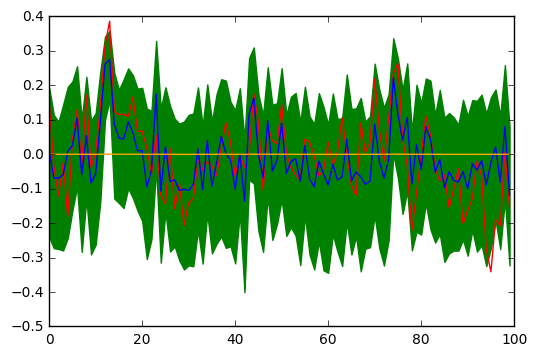

In [30]:
plt.fill_between(range(100),filt_distrib[-100:,3],filt_distrib[-100:,-3],color='green')
plt.plot(latent[-100:],color='red')
plt.plot(filt_distrib.mean(axis=1)[-100:], color='blue')
plt.plot(np.mean(smm[-100:],axis=1), color='orange')
plt.show()

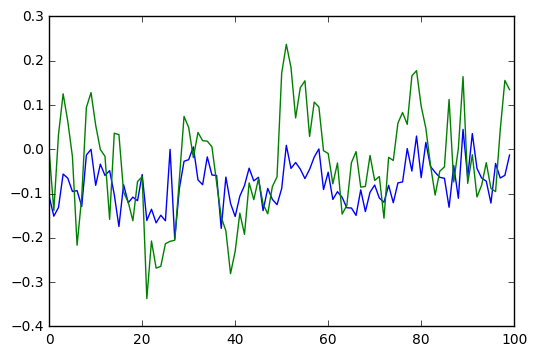

In [44]:
plt.plot(np.mean(smm[-100:],axis=1))
plt.plot(latent[-100:])
plt.show()

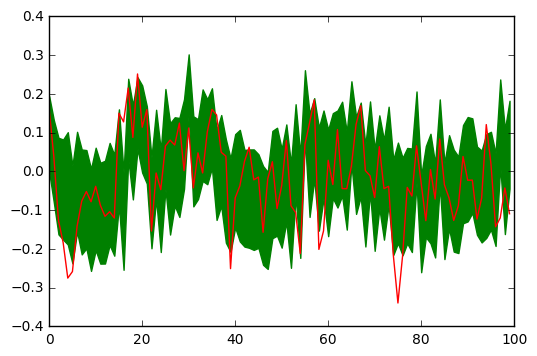

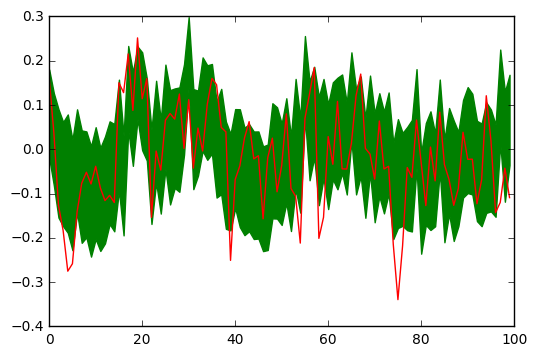

In [23]:
#plt.plot(filtered[-100:])
plt.fill_between(range(100),filt_distrib[-100:,30],filt_distrib[-100:,-30],color='green')
plt.plot(latent[-100:],color='red')
plt.show()
plt.fill_between(range(100),trajectories[-100:, 30],trajectories[-100:, -30],color='green')
plt.plot(latent[-100:], color='red')
plt.show()